In [4]:
from sklearn.decomposition import NMF
from EM_SPADE import EMSPADE
from opt_einsum import contract
import scanpy as sc
import itertools
from scipy.stats import spearmanr
import numpy as np 
import seaborn as sns
import pandas as pd
from pyspade_global import *
import matplotlib.pyplot as plt
import netNMFsc
from sklearn.metrics import roc_curve, auc 

In [5]:
import slalom
from slalom import plotFactors, plotRelevance, saveFA, dumpFA
from util import *

The point of this notebook is to re-do experiments from the slalom paper

In [6]:
def simulate_base_data(N,k,p, scale = 1):
    theta_star = np.random.exponential(scale = scale, size = (p,k))
    theta_star[theta_star < 2] = 0 
    cov = np.eye(k) 
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(k),cov))
        lst.append(a)
    A_star = np.array(lst)
    A_star[A_star < 1] = 0
    global_mean = contract('ik,jk->ij',A_star,theta_star)
    data = np.random.poisson(global_mean)
    return(data,A_star,theta_star)

def create_pathways(n_control_pathways,n_active_pathways, gene_set_size, p, N, overlap,signal_strength):
    ct = 0
    ct2 = 0
    base = np.zeros((n_active_pathways,p))
    lst = []
    gene_sets = []
    for i in range(n_active_pathways):
        base[ct2, ct:ct + gene_set_size] = np.random.exponential(scale = signal_strength, size = gene_set_size)
        gene_sets.append(list(range(ct,ct + gene_set_size)))
        ct = ct + int((1 - overlap)*gene_set_size)
        ct2 = ct2 + 1
    for i in range(n_control_pathways):
        gene_sets.append(list(range(ct,ct + gene_set_size)))
        ct = ct + int((1 - overlap)*gene_set_size)
        ct2 = ct2 + 1
        
    cov = np.eye(n_active_pathways) 
    lst = []
    for i in range(N):
        a = np.exp(np.random.multivariate_normal(np.zeros(n_active_pathways),cov))
        lst.append(a)
    A_star = np.array(lst)
    A_star[A_star < 1] = 0
    global_mean = contract('ik,kj->ij',A_star,base)
    data = np.random.poisson(global_mean)
    return data,base, A_star,gene_sets

def remove(lst,idx):
    lst_return = []
    for i in range(len(lst)):
        if i not in idx:
            lst_return.append(lst[i])
    return lst_return
def noisy_gene_sets(gene_sets,p,FNR,FPR):
    noisy = []
    q = len(gene_sets[0])
    for gene_set in gene_sets:
        
        to_drop = np.random.permutation(len(gene_set))[:int(FNR*q)]
        new_gene_set = remove(gene_set, to_drop)
        new_gene_set = new_gene_set + list(np.random.permutation(p)[:int(FPR*q)])
        noisy.append(new_gene_set)
    return noisy
    

In [7]:
def create_mask(input_lst, G_input, D):
    input_mask = np.zeros((G_input, D))
    for i in range(len(input_lst)):
        for input_ in input_lst[i]:
            input_mask[i,input_]  = 1.0 
    return input_mask

In [8]:
def initialize_total(model,gene_sets,val):    
        """
        form of gene_sets:
        
        cell_type (inc. global) : set of sets of idxs
        """
        
        for ct in model.cell_types:
            assert(model.L[ct] >= len(gene_sets[ct]))
            count = 0
            if model.L[ct] > 0:
                if len(model.adj_matrix[ct]) > 0:
                    for gene_set in gene_sets[ct]:
                        model.theta[ct].data[:,count][gene_set] = val
                        count = count + 1
                    #for i in range(self.L[ct]):
                    #    self.eta[ct].data[i,-1] = -val
                    #    self.eta[ct].data[-1,i] = -val
                    #self.theta[ct].data[:,-1][self.adj_matrix[ct].sum(axis = 1) == 0] = val
                    #self.theta[ct].data[:,-1][self.adj_matrix[ct].sum(axis = 1) != 0] = -val

        assert(model.L["global"] >= len(gene_sets["global"]))
        count = 0
        for gene_set in gene_sets["global"]:
            model.theta["global"].data[:,count][gene_set] = val
            count = count + 1
        #for i in range(self.L["global"]):
        #    self.eta["global"].data[i,-1] = -val
        #    self.eta["global"].data[-1,i] = -val
        #self.theta["global"].data[:,-1][self.adj_matrix["global"].sum(axis = 1) == 0] = val
        #self.theta["global"].data[:,-1][self.adj_matrix["global"].sum(axis = 1) != 0] = -val

## testing fitting and sim functions

In [32]:
#base parameters
n_active_pathways = 5
n_control_pathways = 5
gene_set_size = 20
p = 1000
N = 300 
k = 5
overlap = 0.3
signal_strength = 15
lam = 500/((gene_set_size)*(gene_set_size - 1))
gene_set_FPR = 0.2
gene_set_FNR = 0.2

In [ ]:
roc_slalom = []
roc_spade = []
param_vals = []

In [38]:
for n_active_pathways in [15, 30, 50]:
    for trial in range(5):
        np.random.seed(trial)
        lam = 500/((gene_set_size)*(gene_set_size - 1))
        data2, A_star2, theta_star2 = simulate_base_data(N= N,k = k,p = p)
        data,base, A_star,gene_sets = create_pathways(n_control_pathways,n_active_pathways=n_active_pathways, gene_set_size=gene_set_size,p =p,N=N, overlap = overlap, signal_strength = signal_strength)
        noisy_gs = noisy_gene_sets(gene_sets, p, gene_set_FNR,gene_set_FPR) 
        X = data + data2
        I = create_mask(noisy_gs, G_input = len(noisy_gs), D= p).T.astype(int)
        terms = np.array([str(i) for i in range(I.shape[1])])
        FA = slalom.initFA(Y = X.astype(float), I = I, terms = terms,noise='gauss', nHidden=5, nHiddenSparse=0,do_preTrain=False, minGenes = 1, pruneGenes = False)
        FA.train()
        adj_matrix = np.zeros((p,p))
        for gene_set in noisy_gs:
            for i in gene_set:
                for j in gene_set:
                    if i!=j:
                        adj_matrix[i,j] = 1
        adict = {"global":adj_matrix, "ct": []}
        L = {"global": k + n_active_pathways + n_control_pathways, "ct": 0}
        labels = np.array(N*["ct"])
        gdspade = SPADE(X = X,L = L,labels = labels,adj_matrix = adict,lam = 0.0001,kappa = 0.3,rho = 0.4,delta = 0.2)
        initialize_total(gdspade,{"global": noisy_gs, "ct":[]}, 25.0)
        train(gdspade)
        y = gdspade.theta["global"].softmax(dim = 1).mean(axis = 0).detach().numpy()
        loadings = gdspade.alpha["ct"].exp().detach().numpy()*y.reshape(1,-1)
        to_plot = loadings.mean(axis = 0)
        true_labels = np.array([1]*n_active_pathways + [0]*n_control_pathways)
        normed1 = (to_plot/to_plot.max())[:n_active_pathways + n_control_pathways]
        normed2 = (FA.getRelevance())[k:]
        fpr1, tpr1, _ = roc_curve(true_labels, normed1)
        roc_auc1 = auc(fpr1, tpr1)
        fpr2, tpr2, _ = roc_curve(true_labels, normed2)
        roc_auc2 = auc(fpr2, tpr2)
        roc_spade.append(roc_auc1)
        roc_slalom.append(roc_auc2)
        param_vals.append(n_active_pathways)


iteration 0
Switched off factor 33
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
Switched off factor 28
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


  1%|▏         | 125/10000 [00:00<00:51, 193.52it/s]

UPDATING LR TO 0.5
UPDATING LR TO 0.1


  4%|▎         | 356/10000 [00:01<00:47, 203.29it/s]

UPDATING LR TO 0.01


  6%|▌         | 622/10000 [00:03<00:47, 195.73it/s]


UPDATING LR TO 0.001
UPDATING LR TO 0.0001
iteration 0
Switched off factor 30
iteration 100
iteration 200
Switched off factor 26
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


  1%|          | 84/10000 [00:00<00:47, 207.76it/s]

UPDATING LR TO 0.5


  2%|▏         | 168/10000 [00:00<00:47, 206.72it/s]

UPDATING LR TO 0.1
UPDATING LR TO 0.01


  6%|▌         | 601/10000 [00:02<00:44, 209.74it/s]


UPDATING LR TO 0.001
UPDATING LR TO 0.0001
iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


  1%|          | 107/10000 [00:00<00:47, 206.10it/s]

UPDATING LR TO 0.5
UPDATING LR TO 0.1


  5%|▌         | 515/10000 [00:02<00:48, 194.83it/s]

UPDATING LR TO 0.01


  7%|▋         | 673/10000 [00:03<00:45, 204.49it/s]


UPDATING LR TO 0.001
UPDATING LR TO 0.0001
iteration 0
Switched off factor 31
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


  1%|          | 83/10000 [00:00<00:50, 195.66it/s]

UPDATING LR TO 0.5


  2%|▏         | 165/10000 [00:00<00:49, 197.61it/s]

UPDATING LR TO 0.1


  3%|▎         | 261/10000 [00:01<00:55, 176.08it/s]

UPDATING LR TO 0.01
UPDATING LR TO 0.001


  3%|▎         | 270/10000 [00:01<00:52, 186.09it/s]


UPDATING LR TO 0.0001
iteration 0
Switched off factor 9
Switched off factor 13
iteration 100
iteration 200
iteration 300
Switched off factor 30
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900


  1%|▏         | 145/10000 [00:00<00:49, 200.48it/s]

UPDATING LR TO 0.5
UPDATING LR TO 0.1


  4%|▍         | 434/10000 [00:02<00:48, 199.18it/s]

UPDATING LR TO 0.01


  6%|▌         | 615/10000 [00:03<00:47, 197.14it/s]

UPDATING LR TO 0.001
UPDATING LR TO 0.0001


In [39]:
df = pd.DataFrame()
df["values"] = roc_spade + roc_slalom
df["label"] = ["spade"]*len(roc_spade) + ["slalom"]*len(roc_slalom)
df["p"] = param_vals + param_vals

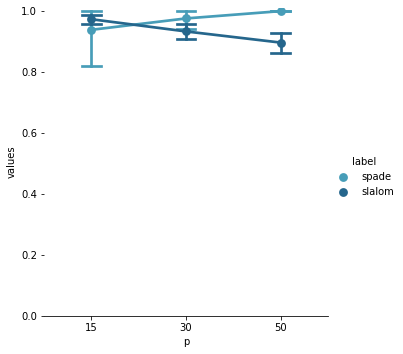

In [42]:
g = sns.catplot(x="p", y="values", hue="label", 
                capsize=.2, palette="YlGnBu_d", 
                kind="point", ci = 95, data=df[df.p > 5])
plt.ylim(0)
g.despine(left=True)
plt.savefig("simulations/og_n_active_pathways.svg")